# Вариант 2

# Задание 1. Классификация

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%time
!unzip -o -q "/content/drive/MyDrive/Colab Notebooks/Data_1_2.zip" -d data

CPU times: user 66.7 ms, sys: 10.9 ms, total: 77.6 ms
Wall time: 14.2 s


Классы: ['fractured', 'not fractured']


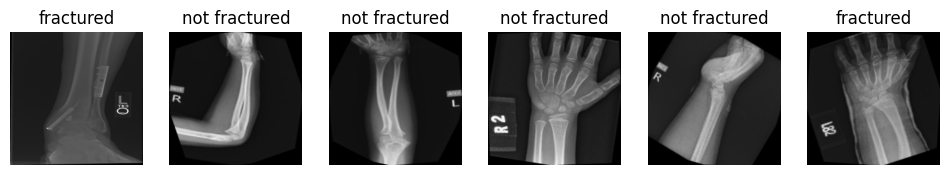

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = r"/content/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Классы:", class_names)

def show_images(images, labels, n=6):
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

sample_images, sample_labels = next(iter(train_loader))
show_images(sample_images, sample_labels)

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
def train_model(model, train_loader, val_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return model

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [20]:
print("Обучение модели 1 (SimpleCNN)")
model1 = SimpleCNN()
model1 = train_model(model1, train_loader, val_loader)

print("\nОбучение модели 2 (DeepCNN)")
model2 = DeepCNN()
model2 = train_model(model2, train_loader, val_loader)

Обучение модели 1 (SimpleCNN)
Epoch 1/5, Loss: 0.2850, Train Acc: 88.36%, Val Acc: 92.88%
Epoch 2/5, Loss: 0.0346, Train Acc: 99.10%, Val Acc: 96.14%
Epoch 3/5, Loss: 0.0101, Train Acc: 99.69%, Val Acc: 97.47%
Epoch 4/5, Loss: 0.0083, Train Acc: 99.82%, Val Acc: 98.19%
Epoch 5/5, Loss: 0.0018, Train Acc: 99.97%, Val Acc: 97.71%

Обучение модели 2 (DeepCNN)
Epoch 1/5, Loss: 0.3235, Train Acc: 85.16%, Val Acc: 95.54%
Epoch 2/5, Loss: 0.0339, Train Acc: 98.86%, Val Acc: 96.26%
Epoch 3/5, Loss: 0.0112, Train Acc: 99.72%, Val Acc: 97.47%
Epoch 4/5, Loss: 0.0036, Train Acc: 99.95%, Val Acc: 99.03%
Epoch 5/5, Loss: 0.0002, Train Acc: 100.00%, Val Acc: 99.03%


In [21]:
acc1 = evaluate_model(model1, test_loader)
acc2 = evaluate_model(model2, test_loader)

if acc1 > acc2:
    best_model = model1
    print(f"Лучшая модель: SimpleCNN с точностью {acc1:.2f}%")
else:
    best_model = model2
    print(f"Лучшая модель: DeepCNN с точностью {acc2:.2f}%")

Лучшая модель: DeepCNN с точностью 99.21%


In [23]:
from PIL import Image
import requests

def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]

img_url = "https://avatars.mds.yandex.net/i?id=ee6766f3923a77d170f0328aaeade63e_sr-9107119-images-thumbs&n=13"
img_path = "fracture_test.jpg"
response = requests.get(img_url)
with open(img_path, "wb") as f:
    f.write(response.content)

result = predict_image(best_model, img_path)
print(f"Предсказанный класс: {result}")

Предсказанный класс: fractured


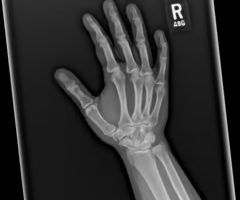

In [24]:
import torchvision.models as models

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 2)
pretrained_model = train_model(pretrained_model, train_loader, val_loader)

pretrained_acc = evaluate_model(pretrained_model, test_loader)
print(f"Точность предобученной модели: {pretrained_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 0.1704, Train Acc: 93.43%, Val Acc: 94.09%
Epoch 2/5, Loss: 0.0566, Train Acc: 97.90%, Val Acc: 91.31%
Epoch 3/5, Loss: 0.0480, Train Acc: 98.22%, Val Acc: 94.93%
Epoch 4/5, Loss: 0.0367, Train Acc: 98.72%, Val Acc: 94.93%
Epoch 5/5, Loss: 0.0271, Train Acc: 99.09%, Val Acc: 95.30%
Точность предобученной модели: 95.45%


Все три модели показали высокую точность на валидационной выборке.

SimpleCNN достигла 98.19%, демонстрируя устойчивость после нескольких эпох.

DeepCNN показала лучший результат (99.03%) и максимальную обобщающую способность.

ResNet18 уступает DeepCNN (95.45%), но остается мощной предобученной моделью.

Лучшая модель — DeepCNN, так как она достигла наивысшей точности.

# Задание 2. Шумоподавляющий автокодировщик.

In [31]:
%%time
!unzip -o -q "/content/drive/MyDrive/Colab Notebooks/Data_2_2.zip" -d data_2

CPU times: user 69.4 ms, sys: 11.2 ms, total: 80.5 ms
Wall time: 13.3 s


In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = r"/content/data_2/NISTDB4_RAW"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train_set"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val_set"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test_set"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Количество тренировочных изображений:", len(train_dataset))
print("Классы:", train_dataset.classes)

Количество тренировочных изображений: 1679
Классы: ['class1_arc', 'class2_whorl', 'class3_loop']


In [33]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (128 -> 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (64 -> 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (32 -> 16)
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (16 -> 32)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # (32 -> 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # (64 -> 128)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder().to(device)

In [34]:
def add_gaussian_noise(images, mean=0, std=0.2):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)


In [35]:
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images).to(device)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    return model

def evaluate_model(model, data_loader):
    model.eval()
    loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images).to(device)
            outputs = model(noisy_images)
            loss += criterion(outputs, images).item()

    return loss / len(data_loader)

In [36]:
print("Обучение шумоподавляющего автокодировщика...")
model = train_model(model, train_loader, val_loader)


Обучение шумоподавляющего автокодировщика...
Epoch 1/10, Loss: 0.0183, Val Loss: 0.0064
Epoch 2/10, Loss: 0.0062, Val Loss: 0.0057
Epoch 3/10, Loss: 0.0058, Val Loss: 0.0058
Epoch 4/10, Loss: 0.0055, Val Loss: 0.0051
Epoch 5/10, Loss: 0.0053, Val Loss: 0.0049
Epoch 6/10, Loss: 0.0051, Val Loss: 0.0049
Epoch 7/10, Loss: 0.0051, Val Loss: 0.0048
Epoch 8/10, Loss: 0.0050, Val Loss: 0.0047
Epoch 9/10, Loss: 0.0050, Val Loss: 0.0047
Epoch 10/10, Loss: 0.0049, Val Loss: 0.0047


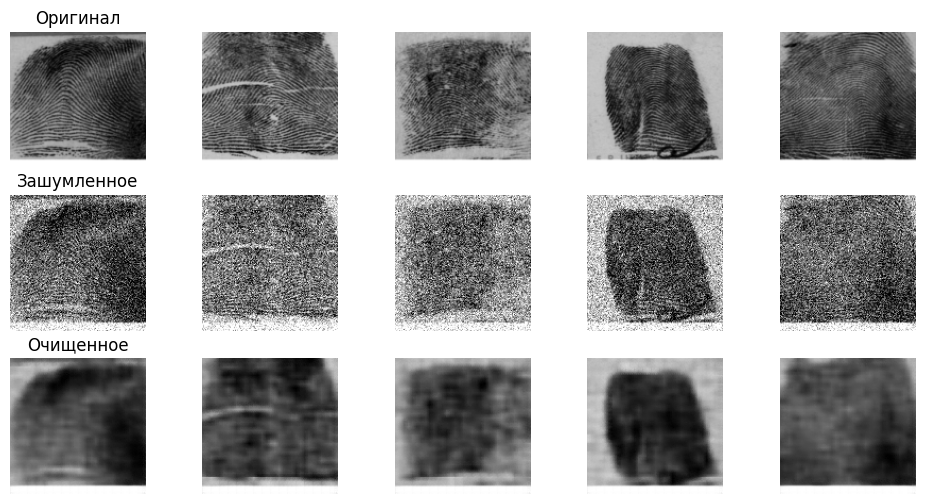

In [37]:
def show_images(model, data_loader):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    noisy_images = add_gaussian_noise(images).to(device)

    with torch.no_grad():
        denoised_images = model(noisy_images)

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    denoised_images = denoised_images.cpu().numpy()

    fig, axes = plt.subplots(3, len(images[:5]), figsize=(12, 6))

    for i in range(len(images[:5])):
        axes[0, i].imshow(images[i][0], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(noisy_images[i][0], cmap="gray")
        axes[1, i].axis("off")
        axes[2, i].imshow(denoised_images[i][0], cmap="gray")
        axes[2, i].axis("off")

    axes[0, 0].set_title("Оригинал")
    axes[1, 0].set_title("Зашумленное")
    axes[2, 0].set_title("Очищенное")
    plt.show()

show_images(model, test_loader)

Модель успешно обучилась: потери снизились, разница между Loss и Val Loss минимальна, переобучения нет. Шумоподавление работает хорошо, но можно улучшить архитектуру или обучать дольше.